#### Learning linear coordinate transformation using TT-parametrized ODE flows

Building on the work in Dektor and Venturi (2023), which investigates the use of coordinate flows for TT-rank reduction, we aim to examine the approximation capabilities of our TT-parametrized ODEs in capturing affine transformations.

##### Rotations

As rotations of the coordinate system can contribute to a significant reduction of a multi-dimensional function's TT-rank, we start our numerical investigations with a regression task, where we want to learn a TT-parametrized ODE flow that infers a linear mapping $f: \R^2 \to \R^2$, $\mathrm{x} \mapsto A\mathrm{x}$, induced by the rotation matrix
$$
A = 
\begin{bmatrix}
\cos(\alpha) & -\sin(\alpha) \\
\sin(\alpha) & \cos(\alpha)
\end{bmatrix}.
$$
Our flow is defined by a time-dependent ODE with a right-hand side represented as FTT, namely
$$
\dot{x}(t) = u_\theta(t, x(t)), \quad t \in [0, T],
$$
where
$$
\ u_\theta(t, x_1, \ldots, x_d) = \sum_{i_1=0}^{m} \cdots \sum_{i_d=0}^{m} 
\hat{U}(i_1, \cdot) \hat{U}(\cdot, i_2, \cdot) \cdots \hat{U}(\cdot, i_{d+1}, \cdot)
P_{i_1}(t) P_{i_2}(x_1) \cdots P_{i_{d+1}}(x_d),
$$
with ranks $r_0 = 1, r_{d+1} = d, r_1 = \ldots, r_d = r$ for any a priori set $r \in \N$. The parameter $\theta$ refers to the TT-cores.

Our goal is to learn the ODE flow's parameters, namely the TT-cores, so that the mapping $g_\theta(\mathrm{x}) = x(T)$ induced by the flow defining ODE with initial condition $x(0) = \mathrm{x}$ approximates the rotation defined by matrix $A$ as close as possible.

Assume that $f: \R^2 \to \R^2$ denotes the linear mapping induced by the rotation matrix $A$.

**Goal:**
$$
\min_\theta \Vert f - g_\theta \Vert_2^2 + \lambda * \Vert \theta \Vert_2^2 \quad \text{subject to} \quad \dot{x}(t) = u_\theta(t, x(t)), \quad t \in [0, T], \quad \text{with} \quad \mathbf{x} \in \R^2,
$$

where the vector $\theta$ captures all the parameters defining the FTT-cores.

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt
import os


from src.basis_functions import OrthonormalBasis, OrthonormalLegendre1D, BSpline1D, Fourier1D
from src.velocity_functions import Func, FuncTT
from src.ode_wrapper import CoordinateFlowODE

from utils.error_funcs import abs_error_func, rel_error_func
from utils.trajectories import plot_vector_fields_at_times, plot_trajectories_over_time

# torch.manual_seed(42)
# np.random.seed(42)

In [3]:
# Generate labeled training data for rotation of radian theta
def generate_rotation_data(n_samples: int = 1000, theta: float = np.pi/2, noise: float = 0.0):
    mean = torch.tensor([0.0, 0.0])
    covariance_matrix = torch.eye(2)
    samples = []
    
    for i in range(n_samples):
        samples.append(torch.distributions.MultivariateNormal(mean, covariance_matrix).sample())
    x = torch.stack(samples)

    # Rotation matrix
    rotation_matrix = torch.tensor([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ], dtype=torch.float32)

    y = x @ rotation_matrix.T
    
    # Add optional noise to the input points
    if noise > 0:
        x += noise * torch.randn(n_samples, 2)

    return x, y

In [4]:
# Generate test data
mean = torch.tensor([0.0, 0.0])    
covariance_matrix = torch.tensor([[1.01, 1.0], [1.0, 1.01]])

# Test data
def sample_data(mean, covariance_matrix, n_samples):
    samples = []
    for i in range(n_samples):
        samples.append(torch.distributions.MultivariateNormal(mean, covariance_matrix).sample())
    return torch.stack(samples)

In [5]:
# Loss function
def loss_func(model, x: torch.Tensor, y: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool, 
              lambda_transport_reg, lambda_tt_reg):
    
    y_pred = model(x, ts, rtol, atol, method, backward)

    l2_transport_cost = model.transport_cost
    
    tt_regularization = sum(torch.norm(core, p="fro") for core in model.func.tt_cores)

    result = ((y_pred - y) ** 2).sum(dim=1) + lambda_transport_reg * l2_transport_cost
    return result.mean() + lambda_tt_reg * tt_regularization

1. **Legendre basis:**

    Begin the experiment by employing a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Legendre polynomial basis of dimension 4**. The experiment is conducted for **FTTs of ranks 4, 8, 16**. 

In [6]:
# Configure a Legendre basis for the FTT on the right-hand side of the ODE
dimension = 4
d = 3

bases = [
        OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 4


In [7]:
# Training parameters
n_samples = 256
n_epochs = 50
batch_size = 64
learning_rate = 1e-3

In [8]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)
data, target = generate_rotation_data(n_samples, theta=np.pi/4)

# Initialize FTTs of rank 4, 8, 16
ftt_rank4 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=2, d_out=2, bases=bases, rank=8, time_dependent=True)
ftt_rank16 = FuncTT(d_in=2, d_out=2, bases=bases, rank=16, time_dependent=True)

model_rank4 = CoordinateFlowODE(ftt_rank4)
model_rank8 = CoordinateFlowODE(ftt_rank8)
model_rank16 = CoordinateFlowODE(ftt_rank16)

# Set the models to training mode and choose optimizer
model_rank4.train()
model_rank8.train()
model_rank16.train()

optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)
optimizer_rank16 = optim.AdamW(model_rank16.parameters(), lr=learning_rate)

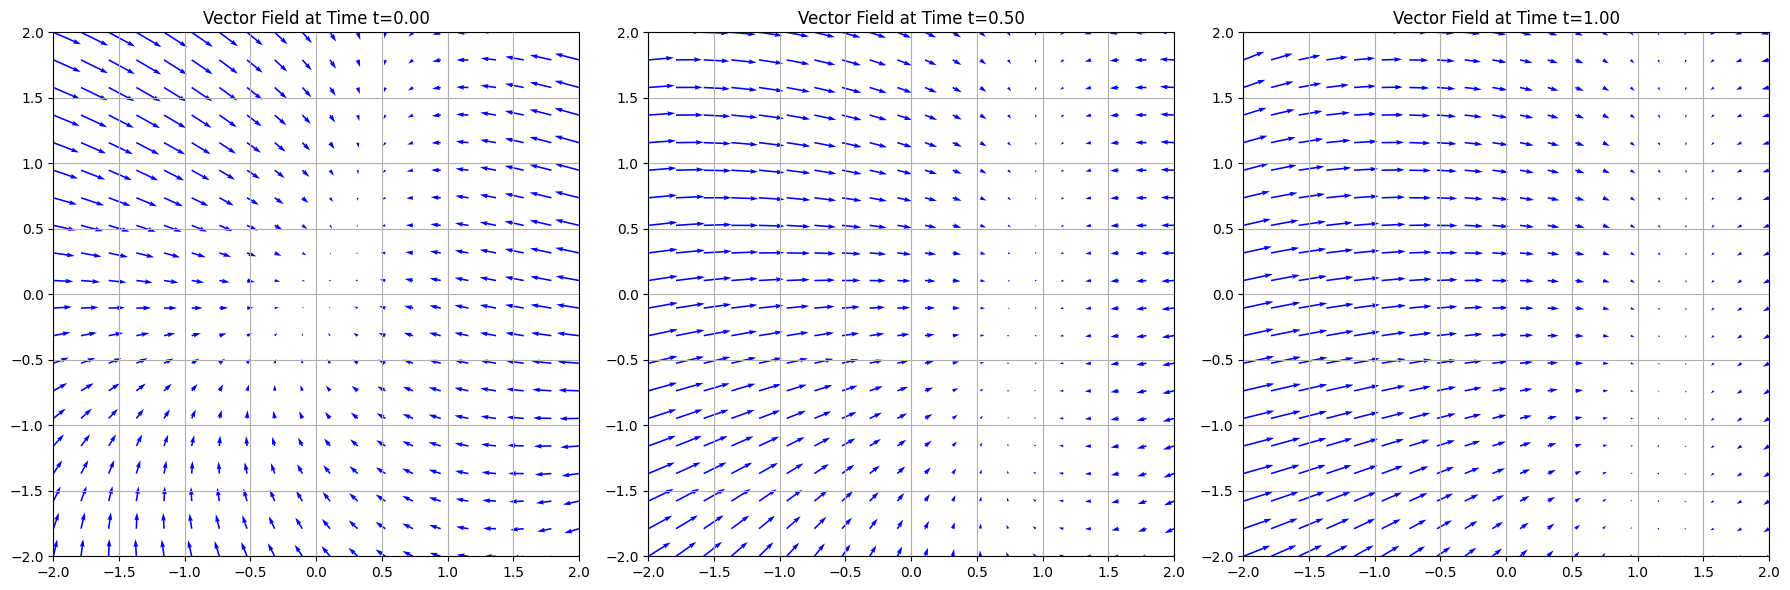

In [10]:
# Plot ODE flow vector field in various points in time before training
plot_vector_fields_at_times(model_rank4.func, x_range = (-2., 2.), y_range = (-2., 2.), plot_time = torch.tensor([0.0, 0.5, 1.0]))

In [11]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-3, lambda_tt_reg = 1e-3):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        epoch_abs_error = 0
        epoch_rel_error = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            epoch_loss += loss.item()

            # Calculate absolute and relative error
            abs_error = abs_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            rel_error = rel_error_func(model, x_batch, y_batch, ts, rtol, atol, method, backward)
            epoch_abs_error += abs_error.item()
            epoch_rel_error += rel_error.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)

        # Compute average absolute and relative error for the epoch
        avg_epoch_abs_error = epoch_abs_error / (n_samples // batch_size)
        avg_epoch_rel_error = epoch_rel_error / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Absolute Error: {avg_epoch_abs_error:.4f}, "
                  f"Relative Error: {avg_epoch_rel_error:.2f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")

    training_dict[training_id] = loss_history

In [12]:
training_dict = {}
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")
training_procedure(model_rank16, data, target, batch_size, n_epochs, optimizer_rank16, training_dict, "Rank 16")


Training Run ID: Rank 4

Epoch [1/50], Loss: 1.1214, Absolute Error: 0.5599, Relative Error: 0.58, Transport Cost: 0.0001
Epoch [2/50], Loss: 1.1193, Absolute Error: 0.5589, Relative Error: 0.58, Transport Cost: 0.0001
Epoch [3/50], Loss: 1.1169, Absolute Error: 0.5577, Relative Error: 0.58, Transport Cost: 0.0001
Epoch [4/50], Loss: 1.1142, Absolute Error: 0.5563, Relative Error: 0.58, Transport Cost: 0.0001
Epoch [5/50], Loss: 1.1111, Absolute Error: 0.5547, Relative Error: 0.58, Transport Cost: 0.0002
Epoch [6/50], Loss: 1.1073, Absolute Error: 0.5529, Relative Error: 0.58, Transport Cost: 0.0003
Epoch [7/50], Loss: 1.1026, Absolute Error: 0.5505, Relative Error: 0.57, Transport Cost: 0.0004
Epoch [8/50], Loss: 1.0971, Absolute Error: 0.5477, Relative Error: 0.57, Transport Cost: 0.0006
Epoch [9/50], Loss: 1.0901, Absolute Error: 0.5442, Relative Error: 0.57, Transport Cost: 0.0008
Epoch [10/50], Loss: 1.0819, Absolute Error: 0.5401, Relative Error: 0.56, Transport Cost: 0.0010
Epo

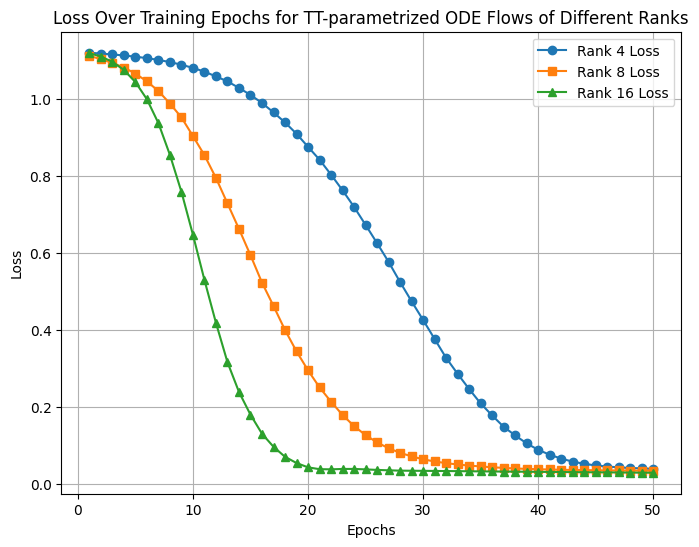

In [13]:
# Number of epochs
n_epochs = len(training_dict["Rank 4"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='o', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='s', label='Rank 8 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 16"], marker='^', label='Rank 16 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_linear coordinate_flows_training_loss_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

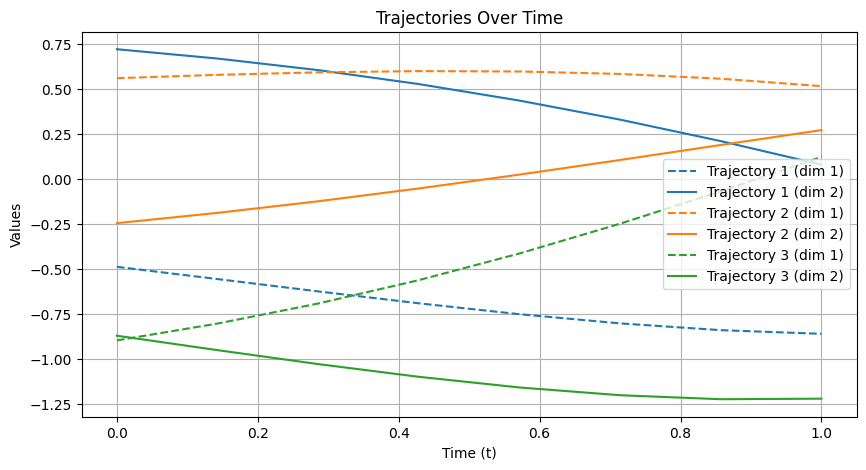

In [17]:
# Plot ODE flow trajectories over time after training
initial_points = torch.rand(3, 2) * 2 - 1
plot_trajectories_over_time(model_rank4.func, initial_points, ts = torch.tensor(np.linspace(0., 1., 8)))

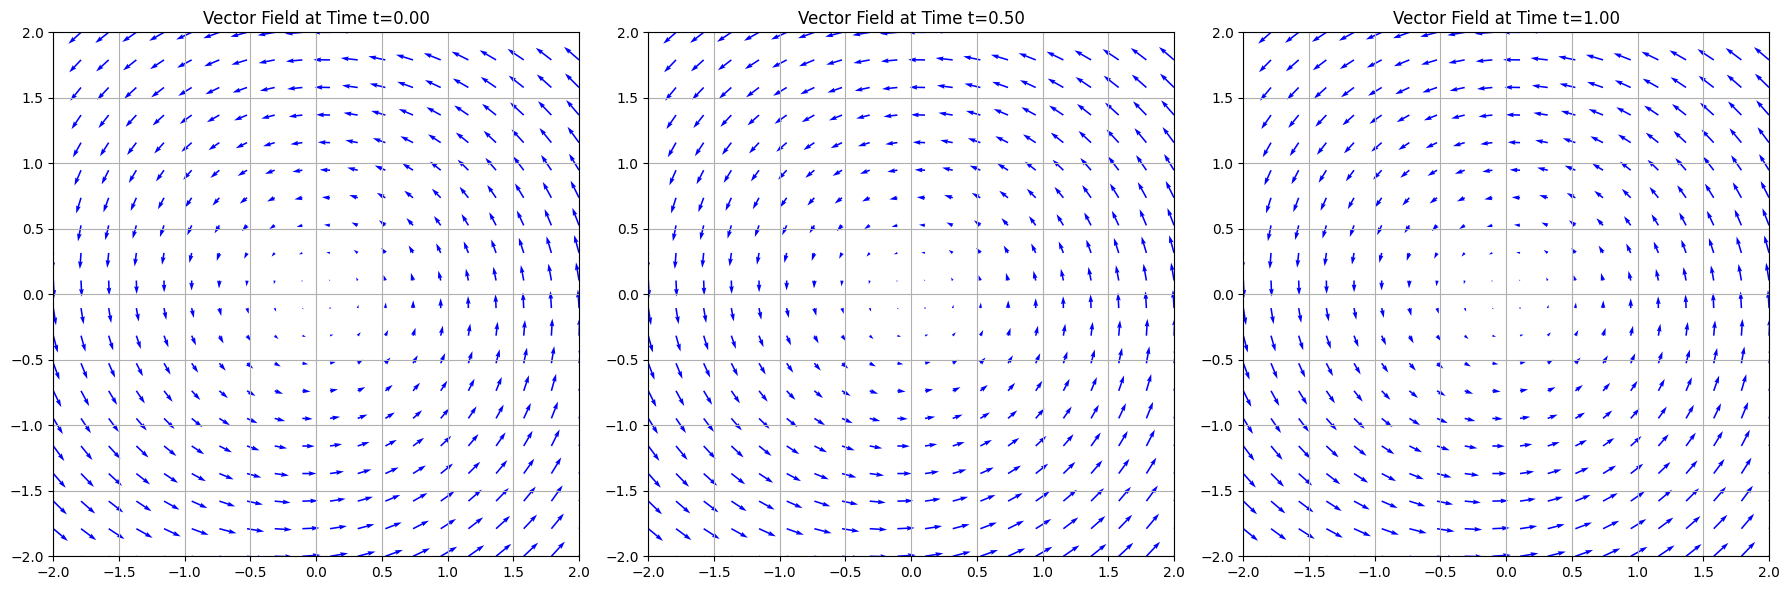

In [18]:
# Plot ODE flow vector field in various points in time after training
plot_vector_fields_at_times(model_rank4.func, x_range = (-2., 2.), y_range = (-2., 2.), plot_time = torch.tensor([0.0, 0.5, 1.0]))

TT-rank 4: Absolute squared error of 0.0625 and relative squared error of 0.06 on test data grid.
TT-rank 8: Absolute squared error of 0.0585 and relative squared error of 0.06 on test data grid.
TT-rank 16: Absolute squared error of 0.0508 and relative squared error of 0.05 on test data grid.


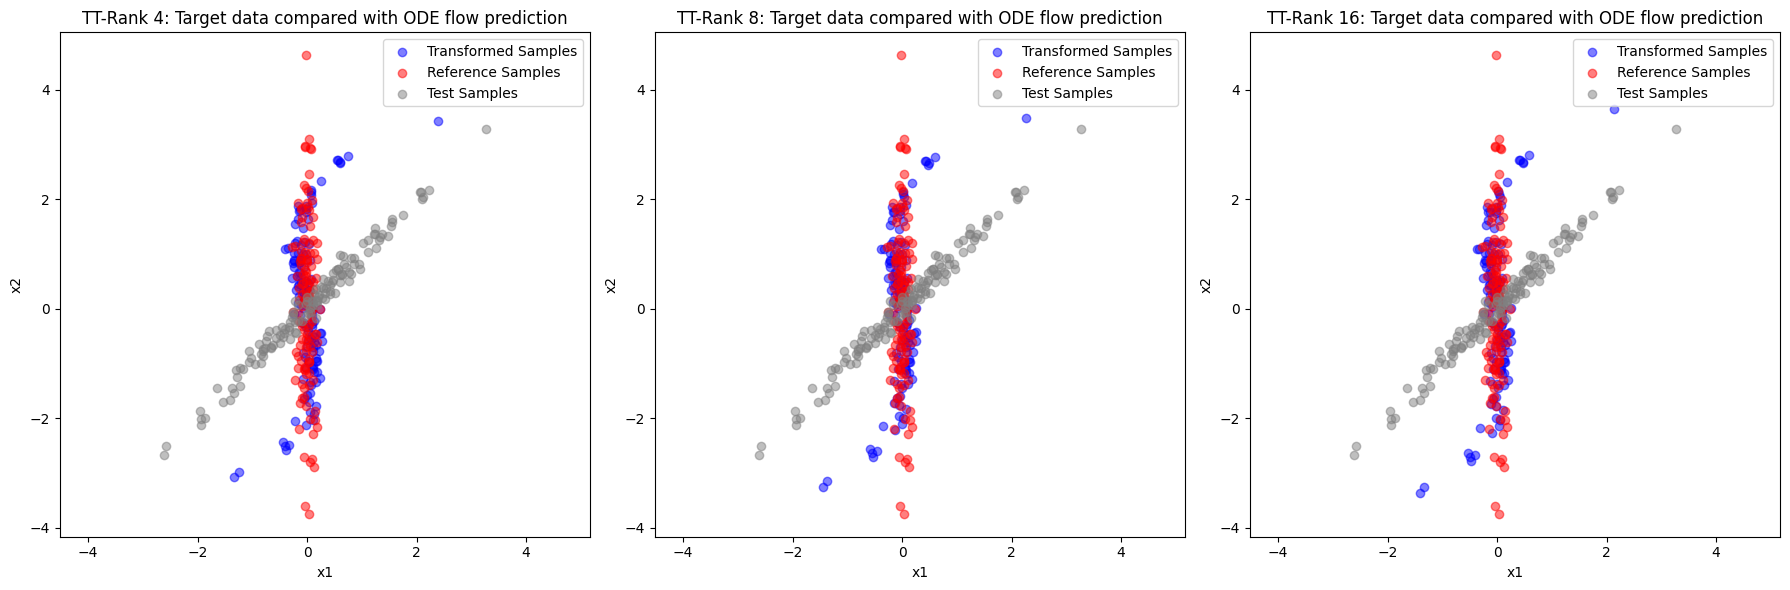

In [19]:
# Function to rotate the data
def rotate_data(x, theta=np.pi/4):
    rotation_matrix = torch.tensor([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ], dtype=torch.float32)
    
    y = x @ rotation_matrix.T
    return y

# Sample some test data for comparison
x_samples = sample_data(mean, covariance_matrix, n_samples=128)

# Generate the target (rotated) data
y_target = rotate_data(x_samples)

# List of models and corresponding ranks
models = [model_rank4, model_rank8, model_rank16]
ranks = [4, 8, 16]

# Print absolute and relative test error
for (model, rank) in zip(models, ranks):
    abs_error = abs_error_func(model, x_samples, y_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    rel_error = rel_error_func(model, x_samples, y_target, ts=torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3 , atol=1e-6, method='euler', backward=False)
    
    print(f"TT-rank {rank}: Absolute squared error of {abs_error:.4f} and relative squared error of {rel_error:.2f} on test data grid.")

# Create figure for subplots
plt.figure(figsize=(18, 6))

# Loop over the models
for i, (model, rank) in enumerate(zip(models, ranks)):
    # Transform samples through the current flow model
    y_pred = model(x_samples, ts = torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3, atol=1e-6, method='euler', backward=False)
    
    # Create a subplot for each model
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_pred[:, 0].detach().numpy(), y_pred[:, 1].detach().numpy(), color='blue', alpha=0.5, label="Transformed Samples")
    plt.scatter(y_target[:, 0].detach().numpy(), y_target[:, 1].detach().numpy(), color='red', alpha=0.5, label="Reference Samples")
    plt.scatter(x_samples[:, 0].detach().numpy(), x_samples[:, 1].detach().numpy(), color='grey', alpha=0.5, label="Test Samples")
    plt.title(f"TT-Rank {rank}: Target data compared with ODE flow prediction")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.axis('equal')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_linear_coordinate_flows_Legendre.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

2. **Fourier basis:**

    Next, employ a FTT representation of the time-dependent right-hand side of the ODE, constructed using a **Fourier  basis of dimension 8**. The experiment is conducted for **FTTs of ranks 4, 8, 16**. 

In [231]:
# Configure a Fourier basis for the FTT on the right-hand side of the ODE
dimension = 8
d = 3

bases = [
        Fourier1D(n=dimension, domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")


Dimension: 8


In [232]:
# Training parameters
n_samples = 256
n_epochs = 50
batch_size = 64
learning_rate = 1e-2

In [233]:
# Initialize data, FTTs of different ranks as well as the coordinate flow ODEs (model)
data, target = generate_rotation_data(n_samples, theta=np.pi/4)

# Initialize FTTs of rank 4, 8, 16
ftt_rank4 = FuncTT(d_in=2, d_out=2, bases=bases, rank=4, time_dependent=True)
ftt_rank8 = FuncTT(d_in=2, d_out=2, bases=bases, rank=8, time_dependent=True)
ftt_rank16 = FuncTT(d_in=2, d_out=2, bases=bases, rank=16, time_dependent=True)

model_rank4 = CoordinateFlowODE(ftt_rank4)
model_rank8 = CoordinateFlowODE(ftt_rank8)
model_rank16 = CoordinateFlowODE(ftt_rank16)

# Set the models to training mode and choose optimizer
model_rank4.train()
model_rank8.train()
model_rank16.train()

optimizer_rank4 = optim.AdamW(model_rank4.parameters(), lr=learning_rate)
optimizer_rank8 = optim.AdamW(model_rank8.parameters(), lr=learning_rate)
optimizer_rank16 = optim.AdamW(model_rank16.parameters(), lr=learning_rate)

In [234]:
# Loss function
def loss_func(model, x: torch.Tensor, y: torch.Tensor, ts: torch.Tensor, rtol: float, atol: float, method: str, backward: bool, 
              lambda_transport_reg, lambda_tt_reg):
    
    y_pred = model(x, ts, rtol, atol, method, backward)

    l2_transport_cost = model.transport_cost

    tt_regularization = sum(torch.norm(core, p="fro") for core in model.func.tt_cores)
    
    result = ((y_pred - y) ** 2).sum(dim=1) + lambda_transport_reg * l2_transport_cost
    return result.mean() + lambda_tt_reg * tt_regularization

In [235]:
# Training loop in a function
def training_procedure(model, data: torch.Tensor, target: torch.Tensor, batch_size: int, n_epochs: int, optimizer: object, 
                       training_dict: dict, training_id: str, ts: torch.Tensor = torch.tensor(np.linspace(0., 1., 8)), 
                       rtol=1e-3, atol=1e-6, method='euler', backward=False, 
                       lambda_transport_reg = 1e-9, lambda_tt_reg = 1e-9):
    
    # List to store epoch loss values
    loss_history = []               
    # Number of samples
    n_samples = data.shape[0]
    # Learning rate
    learning_rate = optimizer_rank4.param_groups[0]['lr']
    # Print Training Run ID
    print(f"\nTraining Run ID: {training_id}\n")

    for epoch in range(n_epochs):
        indices = torch.randperm(n_samples)
        epoch_loss = 0
        for i in range(0, n_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = data[batch_indices]
            y_batch = target[batch_indices]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Calculate loss
            loss = loss_func(model, x_batch, y_batch, ts, rtol, atol, method, backward, lambda_transport_reg, lambda_tt_reg)
            
            epoch_loss += loss.item()
            
            # Backpropagation
            loss.backward()
            optimizer.step()

        # Adapt learning rate during training process
        if epoch == math.floor(n_epochs * 0.1):
            lambda_transport_reg = lambda_transport_reg * 1e-3
            lambda_tt_reg = lambda_tt_reg * 1e-3
        #     learning_rate = learning_rate * 1e-1
        #     optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        if epoch == math.floor(n_epochs * 0.5):
            lambda_transport_reg = lambda_transport_reg * 1e-3
            lambda_tt_reg = lambda_tt_reg * 1e-3
        #     learning_rate = learning_rate * 1e-1
        #     optimizer = optim.AdamW(model.parameters(), lr=learning_rate)   

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / (n_samples // batch_size)
        
        # Store the average loss in the loss_history
        loss_history.append(avg_epoch_loss)
        
        # Print the loss and other metrics
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_epoch_loss:.4f}, "
                  f"Transport Cost: {model.transport_cost.mean():.4f}")
            
    training_dict[training_id] = loss_history

In [236]:
training_dict = {}
training_procedure(model_rank4, data, target, batch_size, n_epochs, optimizer_rank4, training_dict, "Rank 4")
training_procedure(model_rank8, data, target, batch_size, n_epochs, optimizer_rank8, training_dict, "Rank 8")
training_procedure(model_rank16, data, target, batch_size, n_epochs, optimizer_rank16, training_dict, "Rank 16")


Training Run ID: Rank 4

Epoch [1/50], Loss: 1.2168, Transport Cost: 0.0000
Epoch [2/50], Loss: 1.2152, Transport Cost: 0.0000
Epoch [3/50], Loss: 1.2120, Transport Cost: 0.0001
Epoch [4/50], Loss: 1.2059, Transport Cost: 0.0007
Epoch [5/50], Loss: 1.1953, Transport Cost: 0.0015
Epoch [6/50], Loss: 1.1833, Transport Cost: 0.0050
Epoch [7/50], Loss: 1.1737, Transport Cost: 0.0071
Epoch [8/50], Loss: 1.1638, Transport Cost: 0.0087
Epoch [9/50], Loss: 1.1513, Transport Cost: 0.0232
Epoch [10/50], Loss: 1.1429, Transport Cost: 0.0278
Epoch [11/50], Loss: 1.1373, Transport Cost: 0.0257
Epoch [12/50], Loss: 1.1299, Transport Cost: 0.0223
Epoch [13/50], Loss: 1.1222, Transport Cost: 0.0306
Epoch [14/50], Loss: 1.1150, Transport Cost: 0.0257
Epoch [15/50], Loss: 1.1061, Transport Cost: 0.0553
Epoch [16/50], Loss: 1.1018, Transport Cost: 0.0435
Epoch [17/50], Loss: 1.0859, Transport Cost: 0.0630
Epoch [18/50], Loss: 1.0862, Transport Cost: 0.0770
Epoch [19/50], Loss: 1.0804, Transport Cost: 0.

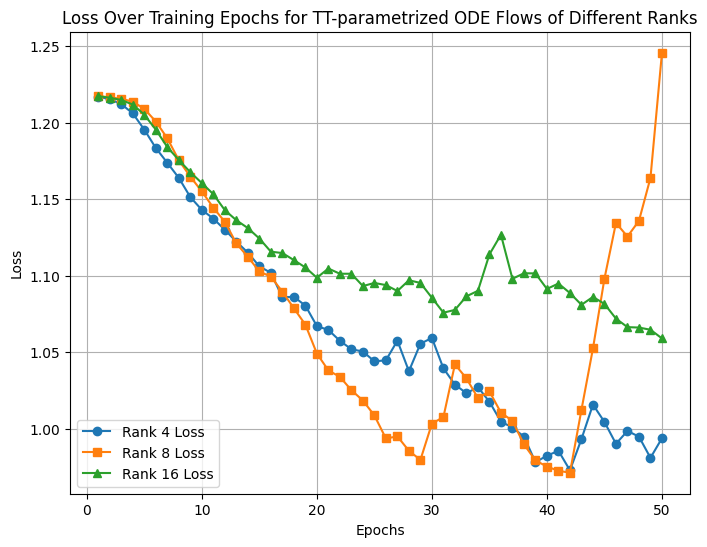

In [237]:
# Number of epochs
n_epochs = len(training_dict["Rank 4"])

plt.figure(figsize=(8, 6))

# Plot the loss values for each Rank
plt.plot(range(1, n_epochs + 1), training_dict["Rank 4"], marker='o', label='Rank 4 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 8"], marker='s', label='Rank 8 Loss')
plt.plot(range(1, n_epochs + 1), training_dict["Rank 16"], marker='^', label='Rank 16 Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Training Epochs for TT-parametrized ODE Flows of Different Ranks')
plt.legend()
plt.grid(True)

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_linear coordinate_flows_training_loss_Fourier.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

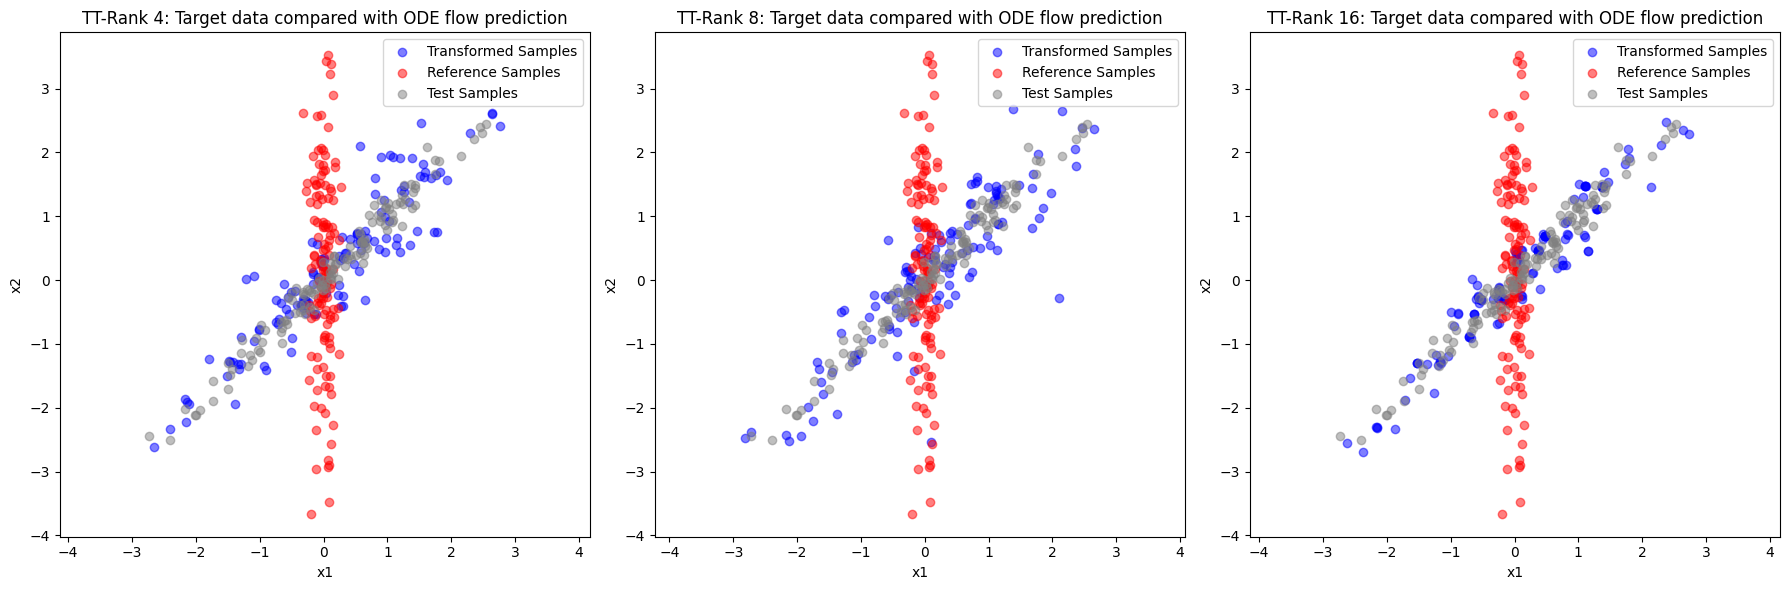

In [238]:
# Function to rotate the data
def rotate_data(x, theta=np.pi/4):
    rotation_matrix = torch.tensor([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ], dtype=torch.float32)
    
    y = x @ rotation_matrix.T
    return y

# Sample some test data for comparison
x_samples = sample_data(mean, covariance_matrix, n_samples=128)

# Generate the target (rotated) data
y_target = rotate_data(x_samples)

# List of models and corresponding ranks
models = [model_rank4, model_rank8, model_rank16]
ranks = [4, 8, 16]

# Create figure for subplots
plt.figure(figsize=(18, 6))

# Loop over the models
for i, (model, rank) in enumerate(zip(models, ranks)):
    # Transform samples through the current flow model
    y_pred = model(x_samples, ts = torch.tensor(np.linspace(0., 1., 8)), rtol=1e-3, atol=1e-6, method='euler', backward=False)
    
    # Create a subplot for each model
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_pred[:, 0].detach().numpy(), y_pred[:, 1].detach().numpy(), color='blue', alpha=0.5, label="Transformed Samples")
    plt.scatter(y_target[:, 0].detach().numpy(), y_target[:, 1].detach().numpy(), color='red', alpha=0.5, label="Reference Samples")
    plt.scatter(x_samples[:, 0].detach().numpy(), x_samples[:, 1].detach().numpy(), color='grey', alpha=0.5, label="Test Samples")
    plt.title(f"TT-Rank {rank}: Target data compared with ODE flow prediction")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.axis('equal')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Save the plots
save_folder = 'ctt_plots'
filename = 'ctt_linear_coordinate_flows_Fourier.png'
save_path = os.path.join(save_folder, filename)
plt.savefig(save_path, bbox_inches='tight')

plt.show()

---

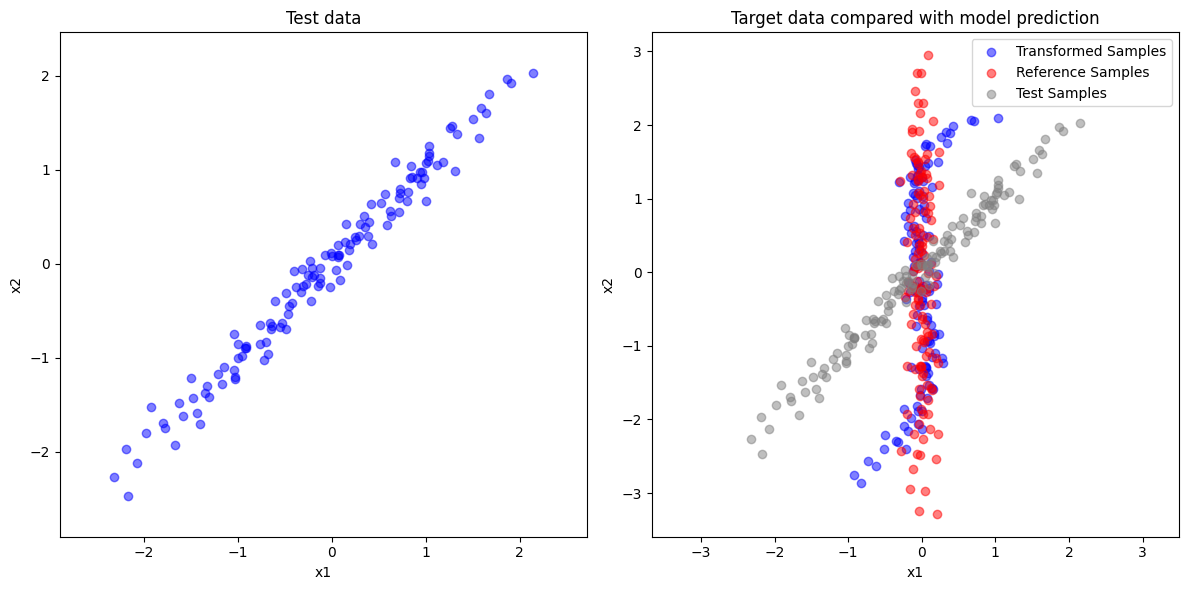

In [132]:
# Some code to analyze single models
x_samples = sample_data(mean, covariance_matrix, n_samples=128)

# Transform samples through the flow
y_pred = model_rank4(x_samples)

# Target rotation
def rotate_data(x, theta=np.pi/4):
    rotation_matrix = torch.tensor([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ], dtype=torch.float32)

    y = x @ rotation_matrix.T
    return y

y_target = rotate_data(x_samples)

# Plot original and transformed distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x_samples[:, 0].detach().numpy(), x_samples[:, 1].detach().numpy(), color='blue', alpha=0.5)
plt.title("Test data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(y_pred[:, 0].detach().numpy(), y_pred[:, 1].detach().numpy(), color='blue', alpha=0.5, label="Transformed Samples")
plt.scatter(y_target[:, 0].detach().numpy(), y_target[:, 1].detach().numpy(), color='red', alpha=0.5, label="Reference Samples")
plt.scatter(x_samples[:, 0].detach().numpy(), x_samples[:, 1].detach().numpy(), color='grey', alpha=0.5, label="Test Samples")
plt.title("Target data compared with model prediction")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.axis('equal')

plt.tight_layout()
plt.show()

In [42]:
# Test easy rotations for single vector
x = torch.tensor([1., 1.])

def A(x, theta=np.pi/4):
    rotation_matrix = torch.tensor([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ], dtype=torch.float32)

    return x @ rotation_matrix.T

print(f"Input : {x}")
print(f"Exact : {A(x)}")
print(f"Approx: {model(x)}")

Input : tensor([1., 1.])
Exact : tensor([0.0000, 1.4142])
Approx: tensor([-0.0174,  1.4052], grad_fn=<SliceBackward0>)
